In [1]:
# !pip install --upgrade diffusers accelerate transformers

In [2]:
import PIL.ImageShow
import numpy as np
import torch
from PIL import Image
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from tqdm.notebook import tqdm

In [3]:
if torch.has_mps:
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
model_name = "google/ddpm-celebahq-256"

In [5]:
pipeline = DDPMPipeline.from_pretrained(model_name)
pipeline = pipeline.to(device)

  0%|          | 0/25 [00:00<?, ?it/s]

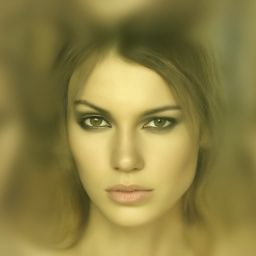

In [6]:
image = pipeline(num_inference_steps=25).images[0]
image

In [7]:
scheduler = DDPMScheduler.from_pretrained(model_name)
model = UNet2DModel.from_pretrained(model_name).to(device)

In [8]:
scheduler.set_timesteps(50)

In [9]:
sample_image_path = "shri-aQ9SJDPadDQ-unsplash.jpg"

sample_image = Image.open(sample_image_path).convert("RGB")
sample_image_size = sample_image.size
sample_size = min(sample_image_size) if min(sample_image_size) < 512 else 512
# sample_size = model.config.sample_size
sample_image = torch.Tensor(
    np.array(
        sample_image
        .resize((sample_size, sample_size),
                Image.LANCZOS))) \
                   .permute(2, 0, 1).unsqueeze(0) \
                   .to(device) / 255

In [10]:
sample_image.real.shape

torch.Size([1, 3, 512, 512])

In [11]:
input = sample_image

for t in tqdm(scheduler.timesteps):
    with torch.no_grad():
        noisy_residual = model(input, t).sample
previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
input = previous_noisy_sample

  0%|          | 0/50 [00:00<?, ?it/s]

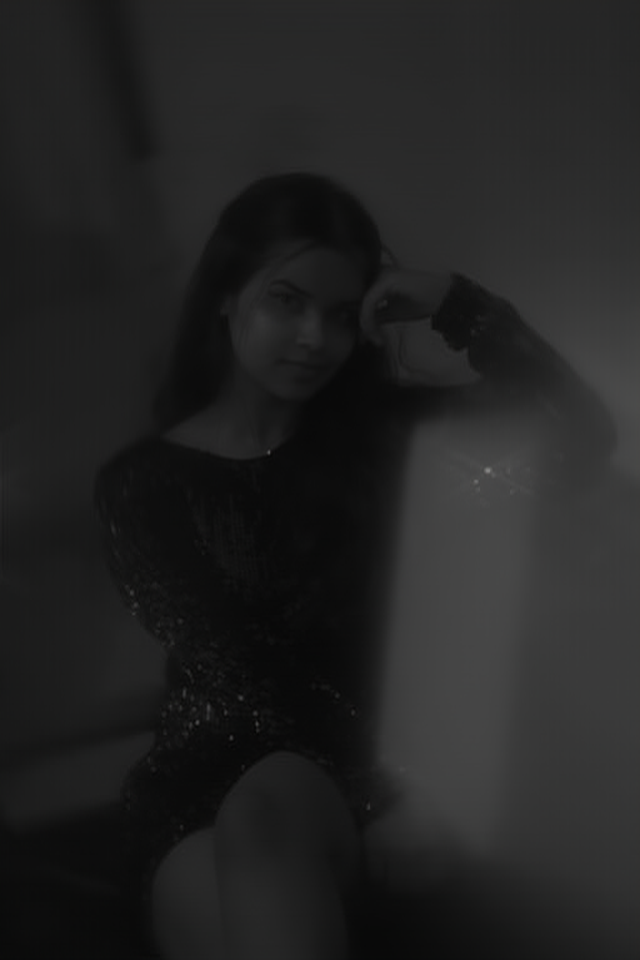

In [12]:
image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image = image.resize(sample_image_size, Image.LANCZOS)
image

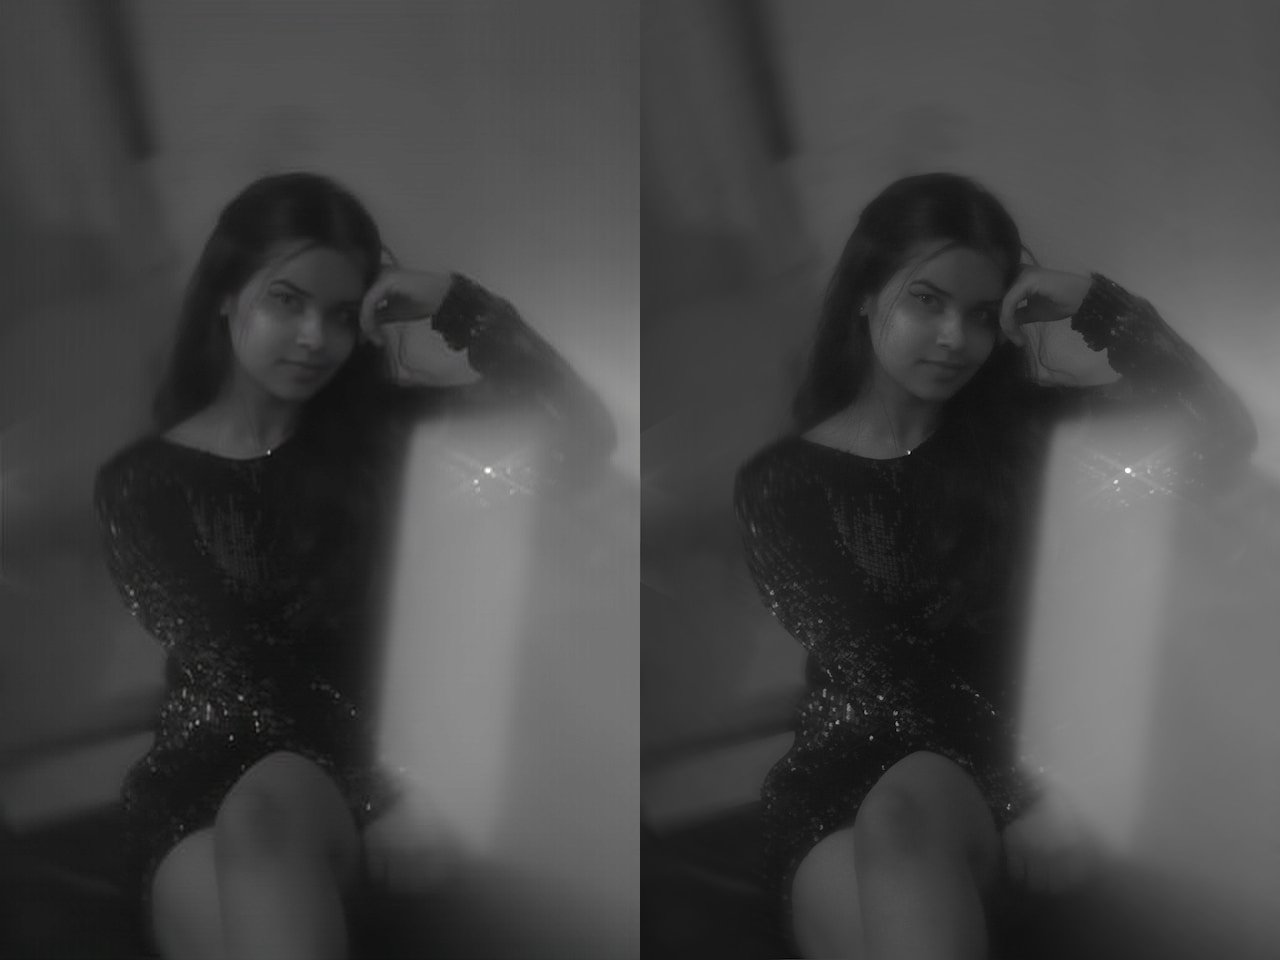

In [13]:
from PIL import ImageEnhance

factor = 2
enhancer = ImageEnhance.Brightness(image)
im_output = enhancer.enhance(factor)

origin_image = PIL.Image.open(sample_image_path).convert("RGB")

# Concatenate the images horizontally.
image = PIL.Image.new("RGB", (im_output.width + origin_image.width, im_output.height))
image.paste(im_output, (0, 0))
image.paste(origin_image, (im_output.width, 0))

# Show the image.
image

In [14]:
# Save image
im_output.save("ddpm_test.png")